In [157]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install matplotlib
# !pip install seaborn

# Data

In [158]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [159]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import datetime
from datetime import timedelta
import scipy.stats as st

In [160]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [161]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")

In [162]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [163]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list ={}

s3 = boto3.resource('s3')
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')

# Metadata

In [50]:
metadata_feature=run_query('''
with runtime_info as (
        select
            viewable_id
            -- different language version has different length,
            -- just take the average for simplicity
            , avg(credits_start_time) as credits_start_time
        from max_prod.catalog.asset_edit_dim as edit
        group by 1
    ),

    metadata as (
        select distinct
            case when content_category = 'series'
                    then ifnull(season_number, 1)
                    else season_number
                        end as season_number_adj
            , coalesce(concat(series_id, '-', season_number_adj), asset.viewable_id) as match_id
            , asset.viewable_id
            , coalesce(concat(series_title_long, ' S', season_number_adj), asset_title_long) as title_name
            , case when program_type is null then 'unknown' else program_type end as program_type
            , asset.content_category
            , credits_start_time
            , release_year
            , licensor
            , descriptive_genre_desc
            , wm_enterprise_genres
            , navigation_genre_desc
    from max_prod.catalog.asset_dim as asset
    -- to get runtime data
    left join runtime_info as edit
        on asset.viewable_id = edit.viewable_id
    )
    
    , meta_agg as (
        select
            m.match_id, title_name
            , season_number_adj
            , mode(m.program_type) as program_type
            , mode(m.content_category) as content_category
            , ifnull(sum(credits_start_time)/3600.0,-1) as total_hours
            , min(release_year) as prod_release_year
            , listagg(distinct lower(licensor), '|') as licensor_agg
            , listagg(distinct lower(descriptive_genre_desc), '|') as descriptive_genre_desc_agg
            , listagg(distinct lower(wm_enterprise_genres), '|') as wm_enterprise_genres_agg
            , listagg(distinct lower(navigation_genre_desc), '|') as navigation_genre_desc_agg
        from metadata as m
        group by 1,2, 3
    ),

    fin_meta_data_table as (
        select distinct
            title_name
            , match_id
            , season_number_adj
            , program_type
            , content_category
            , prod_release_year
            , total_hours
            , licensor_agg
            , descriptive_genre_desc_agg
            , wm_enterprise_genres_agg
            , navigation_genre_desc_agg
        from meta_agg
        order by match_id
    )

    select a.*
        , case when b.viewable_id is null then 0 else 1 end as popcorn_titles
    from fin_meta_data_table a
    left join MAX_PROD.CATALOG.POPCORN_TITLES b
    on a.match_id = b.viewable_id
    order by match_id
''')

In [51]:
## Total Active Base
daily_total_views = run_query('''
                            select TERRITORY,
                            start_date AS available_date,
                            DAYS_SINCE_RELEASE + 1 AS days_on_hbo_max,
                            VIEWING_SUBS AS cumulative_viewing_subs_denom
                            from "MAX_PROD"."CONTENT_ANALYTICS"."CUMULATIVE_SUBS_DENOM_LATAM"
                            where DAYS_SINCE_RELEASE< 28
                            order by start_date
''')

In [52]:
# Daily Actives by title
title_actives = run_query('''
with max_release_date_base as (
select
  distinct
  rad.title_id,
  raod.territory,
  case when rad.season_number is null then title_name else concat(rad.series_title_long,' S',rad.season_number) end as title,
  'Seasons and Movies' as title_level,
  first_value(raod.first_offered_date) over (partition by title order by raod.first_offered_date asc) as first_release_date,
  case when aod.offering_start_date <='2020-05-27 07:00:00' THEN '2020-05-27 07:00:00'
       else aod.offering_start_date end as offering_start_date,
  aod.offering_end_date
  , case when content_category = 'series' then ifnull(season_number, 1) else season_number end as season_number_adj
  , coalesce(concat(rad.series_id, '-', season_number_adj), rad.viewable_id) as match_id
from
  max_prod.catalog.reporting_asset_dim rad
join max_prod.catalog.asset_offering_dim aod
    on rad.viewable_id = aod.viewable_id
        and aod.offering_end_date>= '2021-06-29 09:00:00'
        AND aod.brand = 'HBO MAX'
join max_prod.catalog.reporting_asset_offering_dim raod
  on aod.viewable_id = raod.viewable_id
    AND aod.channel = raod.channel
    AND aod.brand = raod.brand
    AND raod.territory = aod.territory -- leave as HBO MAX domestic because no MUS?
where
  raod.first_offered_date is not null
  and rad.asset_type = 'FEATURE'
--   and offering_start_date<=sysdate()
  and aod.territory in ('BRAZIL', 'ARGENTINA', 'COLOMBIA', 'MEXICO', 'CARIBBEAN', 'REST OF LATAM')
 -- Exclude some odd titles
  and rad.viewable_id not in ('GYGQBcwsaCIW2XgEAAAAL')
    ),
      second as (
        SELECT
           s1.title_id,
           s1.title,
           s1.title_level,
           s1.match_id,
           s1.territory,
           s1.first_release_date,
           s1.offering_start_date,
           MIN(t1.offering_end_date) AS offering_end_date
        FROM max_release_date_base s1
          INNER JOIN max_release_date_base t1 ON s1.offering_start_date <= t1.offering_end_date and s1.title_id=t1.title_id and s1.title=t1.title and s1.title_level=t1.title_level
            AND NOT EXISTS(SELECT * FROM max_release_date_base t2
                           WHERE t1.offering_end_date >= t2.offering_start_date AND t1.offering_end_date < t2.offering_end_date
                            and t1.title_id=t2.title_id and t1.title=t2.title and t1.territory = t2.territory
                          )
        WHERE NOT EXISTS(SELECT * FROM max_release_date_base s2
                           WHERE s1.offering_start_date > s2.offering_start_date AND s1.offering_start_date <= s2.offering_end_date
                            and s1.title_id=s2.title_id and s1.title=s2.title and s1.territory = s2.territory
                          )
        GROUP BY 1,2,3,4,5,6,7
        order by 1,2,3,4,5,6,7
      ),
      third as
        (SELECT
        title_id,
        title,
        title_level,
        match_id,
        territory,
        max(offering_end_date) as end_date
        from second
        group by 1,2,3,4,5),
      fourth as
        (SELECT
         title_id,
        title,
        title_level,
        match_id,
        territory,
        case when end_date>=sysdate() then FALSE
        else TRUE end as is_inactive
        from third),
       fifth as
         (SELECT
         title,
         title_id,
         title_level,
         territory,
         max(days_on_hbo_max) as total_days
        from content_intelligence.new_title_release_days_on_platform_territory_latam
        group by 1,2,3,4)

SELECT c.match_id, c.territory, a.title, a.first_release_date, a.DAILY_VIEWING_SUBS, a.CUMULATIVE_VIEWING_SUBS,
     a.days_on_hbo_max, a.title_id
FROM max_prod.content_intelligence.new_title_release_days_on_platform_territory_latam a
inner join fifth b on initcap(a.title)=initcap(b.title) and a.title_id=b.title_id and a.title_level=b.title_level and a.territory = b.territory
inner join fourth c on initcap(a.title)=initcap(c.title) and a.title_id=c.title_id and a.title_level=c.title_level and a.territory = c.territory
where (days_on_hbo_max between 1 and 28)
''')

In [53]:
title_actives.drop_duplicates(inplace = True)

In [54]:
len(pct_actives.title.unique())

3908

In [55]:
title_actives['available_date'] = title_actives['first_release_date'].astype(str).str[0:10:1]

pct_actives = pd.merge(title_actives[['match_id', 'title', 'title_id', 'days_on_hbo_max', 'territory', 'available_date', 'cumulative_viewing_subs']],
              daily_total_views[['territory', 'available_date', 'days_on_hbo_max', 'cumulative_viewing_subs_denom']],
              on = ['territory', 'available_date', 'days_on_hbo_max'],
              how = 'inner')
pct_actives['pct_actives'] = pct_actives['cumulative_viewing_subs']/pct_actives['cumulative_viewing_subs_denom']*100
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))
pct_actives = pct_actives[['match_id', 'title',  'territory', 'available_date', 'days_on_hbo_max', 'real_date' ,'pct_actives']]

In [56]:
pct_actives=pd.merge(pct_actives,
                      metadata_feature.rename(columns = {'title_name':'id'}), 
                      on = ['match_id'],how = 'left')

In [57]:
recent_originals = pct_actives[(pct_actives['program_type'] == 'original')
                         &(pct_actives['available_date'] > '2021-06-29')
                         ][['match_id', 'days_on_hbo_max', 'available_date']].copy().drop_duplicates()

In [58]:
recent_originals['originals_after_launch'] = 1
recent_originals.drop_duplicates(inplace = True)


In [59]:
pct_actives = pd.merge(pct_actives, recent_originals[['match_id', 'originals_after_launch', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'days_on_hbo_max', 'available_date'], how = 'left')
pct_actives.loc[pct_actives['originals_after_launch'] == 1, 'originals_type'] = 'originals_after_launch'
pct_actives.loc[pct_actives['popcorn_titles'] == 1, 'originals_type'] = 'popcorn_titles'
pct_actives['originals_type'] = pct_actives['originals_type'].fillna(pct_actives['program_type'])
pct_actives = pct_actives.drop(['originals_after_launch', 'popcorn_titles'], axis = 1)

In [60]:
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))

## write to S3

In [62]:
# def to_s3(filename, output_bucket, content):
#     client = boto3.client('s3')
#     client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [63]:
# input_bucket = 'hbo-ingest-datascience-content-dev'

In [64]:
# csv_buffer = io.StringIO()
# pct_actives.to_csv(csv_buffer, index = False)
# content = csv_buffer.getvalue()

# filename = 'pct_actives_prediction/pct_actives_latam_country.csv'

# to_s3(filename, input_bucket, content)

# MODEL

In [65]:
META_COLUMNS = ['match_id',
                'title',
                'available_date',
                'originals_type',
                'content_category',
                'real_date',
                'prediction_start_day',
                'territory'
                ]
TRACKING_COLUMN = {'pct_actives': 'pct_actives',
                 'total_actives': 'total_viewing_accounts',
                 'title_actives': 'title_viewing_accounts',
                 }

In [66]:
class DecayModel:
    def __init__(self, kpi):
        self.tracking_col = TRACKING_COLUMN[kpi]
        self.multiplier_df = None
        
    def fit(self, train_df):
        pct_actives = train_df
        pct_actives_from = pct_actives[['originals_type', 'content_category',
                                    'match_id','prediction_start_day', 'territory', self.tracking_col]]
        pct_actives_from.rename(columns={self.tracking_col: self.tracking_col + '_from'}, inplace=True)


        pct_actives_to = pct_actives[['originals_type', 'content_category',
                                        'match_id','prediction_start_day', 'territory', self.tracking_col]]
        pct_actives_to.rename(columns={self.tracking_col: self.tracking_col + '_to',
                                         'prediction_start_day': 'days_after_launch'}, inplace=True)


        multipliers = pd.merge(pct_actives_from, pct_actives_to,
                           on=['originals_type', 'content_category',
                               'match_id', 'territory'])
        multipliers['multiplier'] = multipliers[self.tracking_col + '_to'] / multipliers[self.tracking_col+ '_from']
        multiplier_df = multipliers.groupby(['originals_type', 'content_category', 'territory', 
                                             'prediction_start_day', 'days_after_launch'],
                                            as_index=False).agg({'multiplier': 'median'})
        self.multiplier_df = multiplier_df
        
    def predict(self, pred_df):
                
        postlaunch_df = pred_df[META_COLUMNS + [self.tracking_col]]
        
        assert self.tracking_col in postlaunch_df.columns


        postlaunch_df = pd.merge(postlaunch_df, self.multiplier_df,
                                 on=['originals_type', 'content_category', 'prediction_start_day', 'territory'],
                                 how='left')
        
        postlaunch_prediction = np.where(postlaunch_df['prediction_start_day'] > postlaunch_df['days_after_launch'],
                                         np.nan,
                                         postlaunch_df[self.tracking_col] * postlaunch_df['multiplier'])

        postlaunch_df['prediction'] = postlaunch_prediction
        
        
        postlaunch_df = postlaunch_df[META_COLUMNS + ['days_after_launch', 'prediction']]
        
        return postlaunch_df

# Cross Validation

In [67]:
bigger_titles = pct_actives[(pct_actives['days_on_hbo_max'] == 28)
                           &(pct_actives['pct_actives'] > 1)]

In [68]:
kpi = 'pct_actives'

data_train_all = pct_actives[(pct_actives['prod_release_year'] >= 2021)
                            &(pct_actives.match_id.isin(bigger_titles.match_id))].copy()

data_train_all.rename(columns={"days_on_hbo_max": "prediction_start_day"}, inplace=True)
data_train_all['real_date'] = data_train_all['real_date'].map(str).map(lambda x: x[:10])
data_train_all['available_date'] = data_train_all['available_date'].map(str).map(lambda x: x[:10])
data_train_all['match_id_territory'] = data_train_all['match_id'] + '_' +  data_train_all['territory']

# logger.info("nrow(features): " + str(len(data_train_all.index)))
print("nrow(features): " + str(len(data_train_all.index)))

validation_set = pd.DataFrame()

num_folds = len(data_train_all['match_id_territory'].unique())
group_kfold = GroupKFold(n_splits=num_folds)
print (group_kfold)

# Train

nrow(features): 20506
GroupKFold(n_splits=746)


In [69]:
len(data_train_all.title.unique())

196

In [101]:
for train_index, test_index in group_kfold.split(data_train_all, groups=data_train_all['match_id_territory'].values):


    train_df, test_df = data_train_all.iloc[train_index], data_train_all.iloc[test_index]
    train_df = train_df[train_df['territory'] == str(test_df['territory'].values[0])]


    avail_date = test_df['available_date'].values[0]
    train_df = train_df[(train_df['available_date'] <= avail_date)]

    print("Validation Title: " + str(test_df['title'].values[0]) + ' at ' + str(test_df['territory'].values[0]))

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_df)
    pred = decay_model.predict(test_df)
    validation_set = pd.concat((validation_set, pred))

validation_set = validation_set[validation_set['days_after_launch'].notnull()]
validation_set.reset_index(drop=True, inplace=True)
# post-process
validation_set.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
validation_set['real_date'] = pd.to_datetime(validation_set['available_date']
                                            ).add(
    validation_set['days_after_launch'].map(lambda x: datetime.timedelta(x))
    ).map(str).map(lambda x: x[:10])

validation_set = pd.merge(validation_set,
                          data_train_all[
                              ['match_id', 'real_date', 'season_number_adj', 'territory'] + [TRACKING_COLUMN[kpi]]],
                          on=['match_id', 'real_date', 'territory'],
                          how='left')

validation_set.rename(columns={TRACKING_COLUMN[kpi]: 'actuals'}, inplace=True)

validation_set = validation_set[['match_id',
                                 'title',
                                 'territory', 
                                 'available_date',
                                 'originals_type',
                                 'content_category',
                                 'prediction_start_date',
                                 'real_date',
                                 'prediction_start_day',
                                 'days_after_launch',
                                 'actuals',
                                 'prediction']]

Validation Title: Insecure S5 at ARGENTINA
Validation Title: The Suicide Squad at REST OF LATAM
Validation Title: Laetitia S1 at BRAZIL
Validation Title: Laetitia S1 at CARIBBEAN
Validation Title: Laetitia S1 at COLOMBIA
Validation Title: Laetitia S1 at MEXICO
Validation Title: Laetitia S1 at REST OF LATAM
Validation Title: Reminiscence at ARGENTINA
Validation Title: Reminiscence at BRAZIL
Validation Title: Reminiscence at CARIBBEAN
Validation Title: Reminiscence at COLOMBIA
Validation Title: Reminiscence at MEXICO
Validation Title: Reminiscence at REST OF LATAM
Validation Title: Scenes From a Marriage S1 at ARGENTINA
Validation Title: Scenes From a Marriage S1 at BRAZIL
Validation Title: Scenes From a Marriage S1 at CARIBBEAN
Validation Title: Scenes From a Marriage S1 at COLOMBIA
Validation Title: Scenes From a Marriage S1 at MEXICO
Validation Title: Scenes From a Marriage S1 at REST OF LATAM
Validation Title: Harry Potter 20th Anniversary: Return to Hogwarts at REST OF LATAM
Validat

In [105]:
validation_set.to_csv('validation_set_post_launch_country_lvel.csv')

# Scoring

In [148]:
pct_actives = pct_actives[(pct_actives['originals_type'] == 'originals_after_launch')
               |(pct_actives['originals_type'] == 'popcorn_titles')]
pct_actives['max_days'] = pct_actives.groupby(['match_id'])['days_on_hbo_max'].transform(max)
pct_actives.rename(columns={"days_on_hbo_max": "prediction_start_day"}, inplace=True)
pct_actives['real_date'] = pct_actives['real_date'].map(str).map(lambda x: x[:10])
pct_actives['available_date'] = pct_actives['available_date'].map(str).map(lambda x: x[:10])
pct_actives['match_id_territory'] = pct_actives['match_id'] + '_' +  pct_actives['territory']

In [149]:
train_df = pct_actives[(pct_actives['max_days'] >= 28)
                      &(pct_actives.match_id.isin(bigger_titles.match_id))]
test_df = pct_actives[(pct_actives['max_days'] < 28)]

In [156]:
pred_df.title.unique()

array(['Real Time with Bill Maher S20', 'Raised by Wolves S2',
       "Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime!",
       'Years and Years S1', "Saudi Women's Driving School",
       'Search Party S5', 'Summer Camp Island S4',
       'Looney Tunes Cartoons S2', 'We Are Who We Are S1',
       'Revolution Rent', 'Tig Notaro: Drawn',
       'Back On the Record with Bob Costas S2', 'Face to Face S2',
       "Ricky Velez: Here's Everything", 'The Gilded Age S1', 'Farruko',
       'The Matrix Resurrections', 'Reik', 'Natti Natasha', 'Nicky Jam',
       'Mau & Ricky', 'Manuel Turizo', 'Good Vibes with Ivete S1',
       'Júpiter', 'The Girl Before S1', 'Camp Lazlo S1', 'Camp Lazlo S2',
       'Camp Lazlo S3', 'Camp Lazlo S4', 'Camp Lazlo S5',
       'And Just Like That... The Documentary',
       'The Club of the Ugly Children S1', 'Sex, Shame and Tears 2',
       'Dating & New York'], dtype=object)

In [151]:
kpi = 'pct_actives'

print("nrow(features): " + str(len(test_df.index)))

pred_df = pd.DataFrame()

# Train
for id, feature in test_df.groupby('match_id_territory'):
    
    print("Scoring Title: " + str(feature['title'].values[0]) + ' at ' + str(feature['territory'].values[0]))    
    avail_date = feature['available_date'].values[0]
    train_features = train_df[(train_df['available_date'] <= avail_date)
                             &(train_df['territory'] == str(feature['territory'].values[0]))]

    # fit_predict decay model
    decay_model = DecayModel(kpi=kpi)
    decay_model.fit(train_features)
    pred = decay_model.predict(feature)
    pred_df = pd.concat((pred_df, pred))
    
pred_df = pred_df[pred_df['days_after_launch'].notnull()]
pred_df.reset_index(drop=True, inplace=True)
# post-process
pred_df.rename(columns={'real_date': 'prediction_start_date'}, inplace=True)
pred_df['realdate'] = pd.to_datetime(pred_df['available_date']
                                    ).add(pred_df['days_after_launch'].map(lambda x: datetime.timedelta(x))
                                    ).map(str).map(lambda x: x[:10])

nrow(features): 1779
Scoring Title: Real Time with Bill Maher S20 at CARIBBEAN
Scoring Title: Raised by Wolves S2 at ARGENTINA
Scoring Title: Raised by Wolves S2 at BRAZIL
Scoring Title: Raised by Wolves S2 at CARIBBEAN
Scoring Title: Raised by Wolves S2 at COLOMBIA
Scoring Title: Raised by Wolves S2 at MEXICO
Scoring Title: Raised by Wolves S2 at REST OF LATAM
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime! at ARGENTINA
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime! at BRAZIL
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime! at CARIBBEAN
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime! at COLOMBIA
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do Storytime! at MEXICO
Scoring Title: Mo Willems and the Storytime All-Stars Present: Don't Let the Pigeon Do S

In [157]:
plot_test = pred_df[(pred_df['title'] == 'Raised by Wolves S2')
                    &(pred_df['prediction_start_day'] == 3)]
plot_actual = test_df[(test_df['title'] == 'Raised by Wolves S2')]

In [160]:
plot_test.head()

,match_id,title,available_date,originals_type,content_category,prediction_start_date,prediction_start_day,territory,days_after_launch,prediction,realdate
616,GX0WFcAlf5r5cuAEAAADu-2,Raised by Wolves S2,2022-02-03,originals_after_launch,series,2022-02-06,3,ARGENTINA,1.0,NaN,2022-02-04
617,GX0WFcAlf5r5cuAEAAADu-2,Raised by Wolves S2,2022-02-03,originals_after_launch,series,2022-02-06,3,ARGENTINA,2.0,NaN,2022-02-05
618,GX0WFcAlf5r5cuAEAAADu-2,Raised by Wolves S2,2022-02-03,originals_after_launch,series,2022-02-06,3,ARGENTINA,3.0,2.166323,2022-02-06
619,GX0WFcAlf5r5cuAEAAADu-2,Raised by Wolves S2,2022-02-03,originals_after_launch,series,2022-02-06,3,ARGENTINA,4.0,2.303914,2022-02-07
620,GX0WFcAlf5r5cuAEAAADu-2,Raised by Wolves S2,2022-02-03,originals_after_launch,series,2022-02-06,3,ARGENTINA,5.0,2.359931,2022-02-08


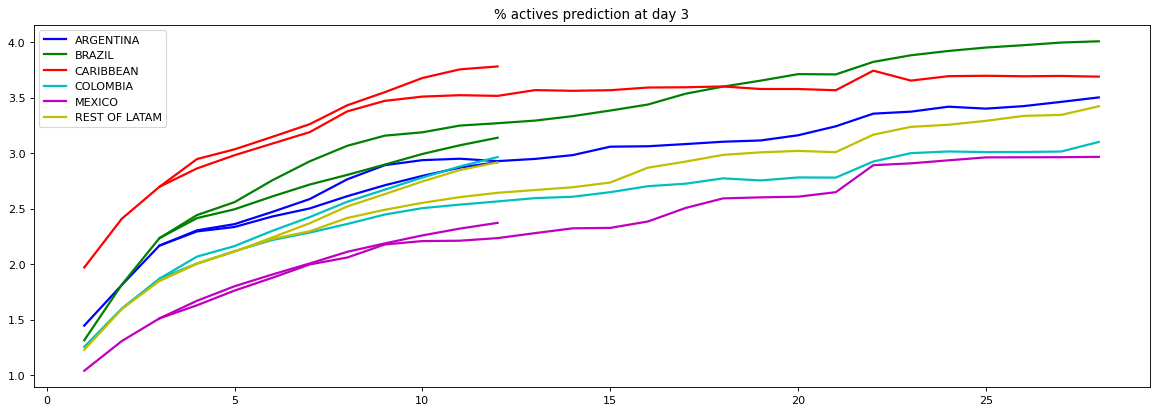

In [159]:
figure(figsize=(18, 6), dpi=80)
color = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'chartreuse'])
for s in plot_test.territory.unique():
    c = next(color)
    plt.plot(plot_test[plot_test['territory']==s]['days_after_launch'], 
             plot_test[plot_test['territory']==s]['prediction'],
                    linewidth=2, label = s, c = c)
    plt.plot(plot_actual[plot_actual['territory']==s]['prediction_start_day'], 
             plot_actual[plot_actual['territory']==s]['pct_actives'],
                    linewidth=2, c = c)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives prediction at day 3')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

# Result Validation

In [7]:
# Cumulative (#) and (%) of Viewing Subscribers
# Unique subscribers who have watched 2 minutes or more of a title

In [8]:
validation_set = pd.read_csv('validation_set_post_launch_country_lvel.csv')
validation_set.drop(['Unnamed: 0'], axis = 1, inplace = True)
validation_set.drop_duplicates(inplace = True)

In [178]:
validation_set=validation_set[validation_set['content_category'] != 'livesports']

In [161]:
def mape_function(group):
    p = group['prediction']
    a = group['actuals']
    return (abs(p - a) / a).mean()

In [162]:
def mpe_function(group):
    p = group['prediction']
    a = group['actuals']
    return ((p - a) / a).mean()

In [186]:
mape_df = validation_set[validation_set['days_after_launch'] == 28]\
            .groupby(['prediction_start_day', 'territory']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['prediction_start_day', 'territory', 'mape']
mape_df.pivot(index='prediction_start_day', columns='territory', values='mape')

territory,ARGENTINA,BRAZIL,CARIBBEAN,COLOMBIA,MEXICO,REST OF LATAM
prediction_start_day,,,,,,
1,0.438693,0.428114,0.403169,0.454981,0.509866,0.436896
2,0.333033,0.336076,0.313360,0.343391,0.380188,0.312627
3,0.277756,0.287095,0.283136,0.288636,0.316831,0.267032
4,0.268198,0.263052,0.262718,0.274889,0.292161,0.253693
5,0.244287,0.241386,0.248220,0.246463,0.273448,0.231303
6,0.230008,0.221038,0.243174,0.239691,0.260234,0.217810
7,0.227037,0.209837,0.230331,0.223155,0.238924,0.205292
8,0.206012,0.194804,0.212232,0.204063,0.216284,0.186449
9,0.190125,0.180315,0.193976,0.186940,0.196717,0.169845


In [181]:
# Mape by Category
mape_df = validation_set[validation_set['days_after_launch'] == 28]\
        .groupby(['originals_type','content_category', 'prediction_start_day']).apply(mape_function)
mape_df = pd.DataFrame(mape_df).reset_index()
mape_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'mape']
mape_df.pivot(index=['originals_type', 'content_category'], columns='prediction_start_day', values='mape')

prediction_start_day                           1         2         3   \
originals_type         content_category                                 
acquired               movies            0.367532  0.334192  0.275246   
                       series            0.473983  0.397045  0.342507   
original               movies            0.682803  0.516188  0.468598   
                       series            0.367815  0.353715  0.340846   
originals_after_launch movies            0.544327  0.311091  0.258334   
                       series            0.485045  0.341834  0.302921   
                       special           1.201241  1.119130  0.952708   
popcorn_titles         movies            0.286448  0.153115  0.086513   

prediction_start_day                           4         5         6   \
originals_type         content_category                                 
acquired               movies            0.232037  0.205267  0.193417   
                       series            0.328642  0.287526  0.266046   
original               movies            0.442977  0.448750  0.461814   
                       series            0.352180  0.362274  0.363617   
originals_after_launch movies            0.245916  0.207977  0.167853   
                       series            0.291008  0.273360  0.264037   
                       special           0.778882  0.635835  0.571818   
popcorn_titles         movies            0.080647  0.075990  0.068555   

prediction_start_day                           7         8         9   \
originals_type         content_category                                 
acquired               movies            0.178306  0.160991  0.142869   
                       series            0.243607  0.221203  0.201364   
original               movies            0.421090  0.410808  0.400932   
                       series            0.348378  0.338707  0.333326   
originals_after_launch movies            0.165414  0.145543  0.186751   
                       series            0.255442  0.230473  0.205086   
                       special           0.540128  0.476271  0.379895   
popcorn_titles         movies            0.065215  0.061750  0.055764   

prediction_start_day                           10        11        12  \
originals_type         content_category                                 
acquired               movies            0.127531  0.112134  0.102304   
                       series            0.184297  0.165975  0.150576   
original               movies            0.356108  0.310863  0.251387   
                       series            0.312331  0.286795  0.274384   
originals_after_launch movies            0.195552  0.180510  0.170059   
                       series            0.187341  0.177127  0.170814   
                       special           0.267335  0.200556  0.161642   
popcorn_titles         movies            0.050355  0.046806  0.042139   

prediction_start_day                           13        14        15  \
originals_type         content_category                                 
acquired               movies            0.094452  0.087084  0.078839   
                       series            0.135410  0.126368  0.113153   
original               movies            0.232654  0.213644  0.197709   
                       series            0.245569  0.226948  0.180580   
originals_after_launch movies            0.168267  0.155873  0.142027   
                       series            0.161743  0.149696  0.128745   
                       special           0.119483  0.091593  0.074664   
popcorn_titles         movies            0.039592  0.037596  0.033768   

prediction_start_day                           16        17        18  \
originals_type         content_category                                 
acquired               movies            0.069112  0.061424  0.052043   
                       series            0.101105  0.089245  0.079507   
original               movies            0.178354  0.

In [182]:
validation_set['mape'] = np.abs(validation_set['prediction'] -validation_set['actuals'])/validation_set['actuals']

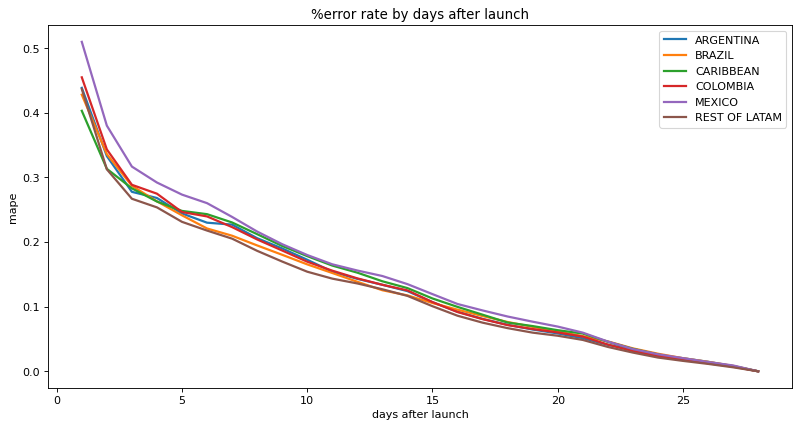

In [187]:
plot_df = mape_df

figure(figsize=(12, 6), dpi=80)
for s in plot_df.territory.unique():
    plt.plot(plot_df[(plot_df['territory'] == s)]['prediction_start_day'], 
         plot_df[(plot_df['territory'] == s)]['mape'],
         linewidth=2, label = s)
plt.title('%error rate by days after launch')
plt.xlabel('days after launch')
plt.ylabel('mape')
plt.legend()
plt.show()

In [189]:
plot_df = validation_set.groupby(['title', 'available_date','originals_type', 'prediction_start_day']).apply(mpe_function)
plot_df = pd.DataFrame(plot_df).reset_index()
plot_df.columns = ['title', 'available_date', 'originals_type', 'prediction_start_day', 'mape']
plot_df = plot_df[plot_df['prediction_start_day'] == 7]
plot_df['available_date'] = pd.to_datetime(plot_df['available_date'], format='%Y-%m-%d')

In [190]:
plot_df.loc[plot_df['originals_type'] == 'originals_after_launch', 'color'] = 1
plot_df.loc[plot_df['originals_type'] == 'popcorn_titles', 'color'] = 2

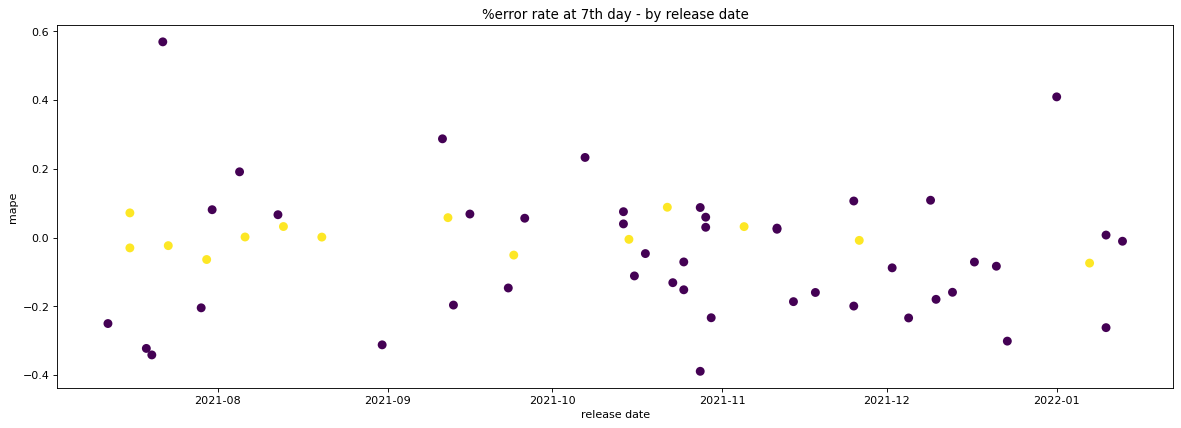

In [191]:
figure(figsize=(18, 6), dpi=80)
plt.scatter(plot_df['available_date'], plot_df['mape'], c = plot_df['color'],
                linewidth=2)
plt.title('%error rate at 7th day - by release date')
plt.xlabel('release date')
plt.ylabel('mape')
# plt.legend()
plt.show()

In [20]:
validation_set['pct_error'] = (validation_set['prediction']-validation_set['actuals'])/validation_set['actuals']
validation_set['multiplier'] = (1/(1+validation_set['pct_error']))

In [21]:
validation_set[(validation_set['pct_error'] > 1000)].content_category.unique()

array(['livesports'], dtype=object)

In [22]:
data = validation_set[(validation_set['originals_type'] == 'originals_after_launch') 
                      & (validation_set['content_category'] == 'series') 
                      & (validation_set['days_after_launch'] == 26)
                      & (validation_set['prediction_start_day'] == 5)
                     &(validation_set['pct_error'].notnull())]#['pct_error']

In [23]:
def ci_calculation(data, ci_level = 0.95, field = 'multiplier'):
    data = data[data[field].notnull()][field]
    lower, upper = st.t.interval(alpha=ci_level, 
                         df=len(data)-1, 
                         loc=np.mean(data), 
                         scale=st.sem(data)) 
    return lower, upper

In [24]:
ci_df = validation_set.groupby(['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch']).apply(ci_calculation)
ci_df = pd.DataFrame(ci_df).reset_index()
ci_df.columns = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch', 'multiplier']
ci_df['lower_index'], ci_df['upper_index'] = zip(*ci_df['multiplier'])
ci_df['lower_index'] = ci_df['lower_index'].fillna(1)
ci_df['upper_index'] = ci_df['upper_index'].fillna(1)
ci_df.drop(['multiplier'], axis = 1, inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
validation_set = pd.merge(validation_set, ci_df, on = ['originals_type', 'content_category', 'prediction_start_day', 'days_after_launch'],
                         how = 'left')
# validation_set['upper_bound'] = validation_set['prediction']/(1+validation_set['lower_index'])
# validation_set['lower_bound'] = validation_set['prediction']/(1+validation_set['upper_index'])
validation_set['upper_bound'] = validation_set['prediction']*validation_set['upper_index']
validation_set['lower_bound'] = validation_set['prediction']*validation_set['lower_index']

In [ ]:
validation_set

In [192]:
plot_df = validation_set[(validation_set['title'].str.contains('Before I Forget'))
                        &(validation_set['prediction_start_day'] == 7)]

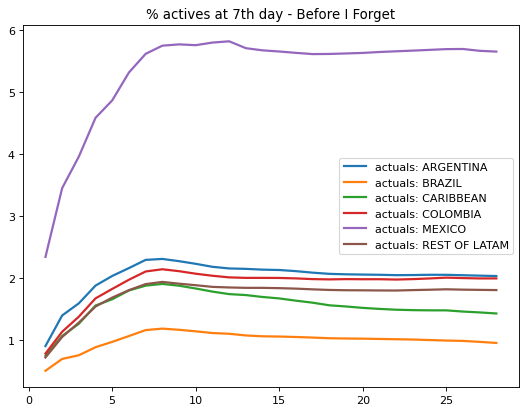

In [193]:
figure(figsize=(8, 6), dpi=80)
for s in plot_df.territory.unique():
#     plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
#              plot_df[plot_df['sub_region'] == s]['prediction'],
#                     linewidth=2, label = 'prediction: '+s)
    plt.plot(plot_df[plot_df['territory'] == s]['days_after_launch'], 
             plot_df[plot_df['territory'] == s]['actuals'],
                    linewidth=2, label = 'actuals: '+s)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - Before I Forget')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [27]:
plot_df = validation_set[(validation_set['title_name'] == 'The Missing')
                        &(validation_set['prediction_start_day'] == 7)]

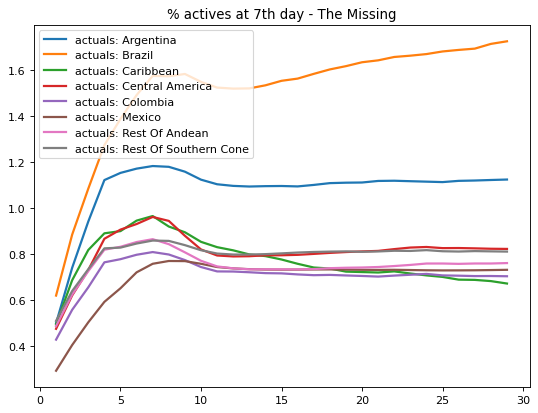

In [29]:
figure(figsize=(8, 6), dpi=80)
for s in plot_df.sub_region.unique():
#     plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
#              plot_df[plot_df['sub_region'] == s]['prediction'],
#                     linewidth=2, label = 'prediction: '+s)
    plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
             plot_df[plot_df['sub_region'] == s]['actuals'],
                    linewidth=2, label = 'actuals: '+s)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - The Missing')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [30]:
plot_df = validation_set[(validation_set['title_name'] == 'Rap Battlefield')
                        &(validation_set['prediction_start_day'] == 7)]

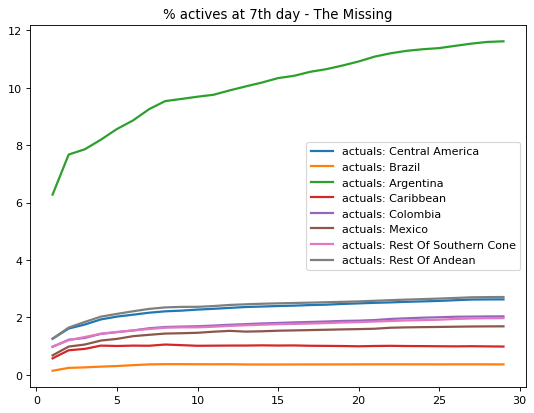

In [34]:
figure(figsize=(8, 6), dpi=80)
for s in plot_df.sub_region.unique():
#     plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
#              plot_df[plot_df['sub_region'] == s]['prediction'],
#                     linewidth=2, label = 'prediction: '+s)
    plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
             plot_df[plot_df['sub_region'] == s]['actuals'],
                    linewidth=2, label = 'actuals: '+s)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - The Missing')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [37]:
plot_df = validation_set[(validation_set['title_name'].str.contains('A Thousand Fangs'))
                        &(validation_set['prediction_start_day'] == 7)]

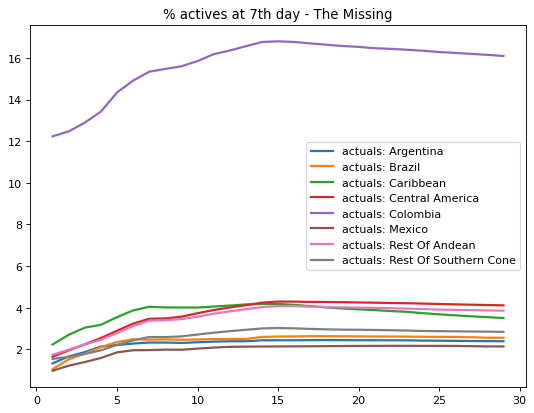

In [38]:
figure(figsize=(8, 6), dpi=80)
for s in plot_df.sub_region.unique():
#     plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
#              plot_df[plot_df['sub_region'] == s]['prediction'],
#                     linewidth=2, label = 'prediction: '+s)
    plt.plot(plot_df[plot_df['sub_region'] == s]['days_after_launch'], 
             plot_df[plot_df['sub_region'] == s]['actuals'],
                    linewidth=2, label = 'actuals: '+s)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% actives at 7th day - The Missing')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

# Checks

In [145]:
pct_actives[(pct_actives['days_on_hbo_max'] == 27)].sort_values(by = ['pct_actives'], ascending = False)\
[['title_name', 'available_date', 'actives', 'pct_actives']].head(10)

,title_name,available_date,actives,pct_actives
59972,Space Jam: A New Legacy,2021-08-20,2353737,40.499472
80988,Godzilla vs. Kong,2021-07-16,1718557,31.983531
65886,Mortal Kombat,2021-08-06,1601557,28.263412
51870,Wonder Woman 1984,2021-06-29,1041971,23.396861
84210,The Suicide Squad,2021-09-12,1300661,22.745099
84211,The Suicide Squad,2021-09-12,1182979,20.687154
64148,The Conjuring: The Devil Made Me Do It,2021-07-09,997791,19.122016
50528,Friends: The Reunion,2021-06-29,831837,18.678422
51891,Zack Snyder's Justice League,2021-06-29,766873,17.219693
64152,Tom & Jerry,2021-07-09,883159,16.925168


In [269]:
pct_actives[(pct_actives['end_date'] == '2021-10-11')
           &(pct_actives['start_date'] == '2021-10-09')].sort_values(by = ['actives'])

,match_id,title_name,prediction_start_day,available_date,actives,start_date,end_date,actives_base,pct_actives,id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg,originals_type,real_date
64540,GXwzPRAf5ncPDwgEAAAcY,Rose Matafeo: Horndog,2,2021-10-09,13,2021-10-09,2021-10-11,2748308,0.000473,Rose Matafeo: Horndog,1-GXwzPRAf5ncPDwgEAAAcY,-1.0,2020-08-20 07:01:00.000,1.0,original,special,1.0,0.0,1.0,4.0,0.955000,2020.0,0.00000,"avalon television limited, warner media direct...",comedy|original|stand-up comedy,comedy,comedy|original|stand-up comedy,originals_after_launch,2021-10-11
64534,GYOykUABM3sPDwgEAAAe6-1,Back On the Record with Bob Costas,2,2021-10-09,78,2021-10-09,2021-10-11,2748308,0.002838,Back On the Record with Bob Costas S1,1-GYOykUABM3sPDwgEAAAe6-1,1.0,2021-07-31 06:00:00.000,1.0,original,series,0.0,1.0,1.0,6.0,2.866806,2021.0,0.00274,hbo original,sport,news/talk | sports | documentary | originals|s...,documentary | sport|documentary | original | s...,originals_after_launch,2021-10-11
64539,GYC1puQhu1cLCwgEAAAA0,Persona: The Dark Truth Behind Personality Tests,2,2021-10-09,826,2021-10-09,2021-10-11,2748308,0.030055,Persona: The Dark Truth Behind Personality Tests,1-GYC1puQhu1cLCwgEAAAA0,-1.0,2021-03-04 08:01:00.000,1.0,original,movies,1.0,0.0,1.0,4.0,1.417500,2021.0,0.00000,"go there productions, warner media direct, llc",documentary,documentary,documentary,originals_after_launch,2021-10-11


In [146]:
# Daily Actives by title
title_actives_us = run_query('''
with max_release_date_base as (

        select
          distinct
          rad.title_id,
          case
            when rad.season_number is null
                then title_name
            else concat(rad.series_title_long,' S',rad.season_number)
          end as title,
          'Seasons and Movies' as title_level,
          first_value(raod.first_offered_date) over (partition by title order by raod.first_offered_date asc) as first_release_date,
          case
            when aod.offering_start_date <='2020-05-27 07:00:00' THEN '2020-05-27 07:00:00'
            else aod.offering_start_date
          end as offering_start_date,
          aod.offering_end_date
          , case when content_category = 'series'
            then ifnull(season_number, 1)
            else season_number
                end as season_number_adj
        , coalesce(concat(rad.series_id, '-', season_number_adj), rad.viewable_id) as match_id
        from
          max_prod.catalog.reporting_asset_dim rad
        join max_prod.catalog.asset_offering_dim aod
            on rad.viewable_id = aod.viewable_id
                and aod.offering_end_date>='2020-05-27 07:00:00'
                AND aod.brand = 'HBO MAX'
        join max_prod.catalog.reporting_asset_offering_dim raod
          on aod.viewable_id = raod.viewable_id
            AND aod.channel = raod.channel
            AND aod.brand = raod.brand
            AND raod.territory = aod.territory -- leave as HBO MAX domestic because no MUS?
        where
          raod.first_offered_date is not null
          and rad.asset_type = 'FEATURE'
          and offering_start_date<=sysdate()
          and aod.territory='HBO MAX DOMESTIC'
      ),
      second as (
        SELECT
           s1.title_id,
           s1.match_id,
           s1.title,
           s1.title_level,
           s1.first_release_date,
           s1.offering_start_date,
           MIN(t1.offering_end_date) AS offering_end_date
        FROM max_release_date_base s1
          INNER JOIN max_release_date_base t1 ON s1.offering_start_date <= t1.offering_end_date and s1.title_id=t1.title_id and s1.title=t1.title and s1.title_level=t1.title_level
            AND NOT EXISTS(SELECT * FROM max_release_date_base t2
                           WHERE t1.offering_end_date >= t2.offering_start_date AND t1.offering_end_date < t2.offering_end_date
                            and t1.title_id=t2.title_id and t1.title=t2.title
                          )
        WHERE NOT EXISTS(SELECT * FROM max_release_date_base s2
                           WHERE s1.offering_start_date > s2.offering_start_date AND s1.offering_start_date <= s2.offering_end_date
                            and s1.title_id=s2.title_id and s1.title=s2.title
                          )
        GROUP BY 1,2,3,4,5, 6
        order by 1,2,3,4,5, 6
      ),
      third as
        (SELECT
        title_id,
        title,
        title_level,
        match_id,
        max(offering_end_date) as end_date
        from second
        group by 1,2,3,4),
      fourth as
        (SELECT
         title_id,
        title,
        title_level,
        match_id,
        case when end_date>=sysdate() then FALSE
        else TRUE end as is_inactive
        from third),
       fifth as
         (SELECT
         title,
         title_id,
         title_level,
         max(days_on_hbo_max) as total_days
        from content_intelligence.new_title_release_days_on_platform
        group by 1,2,3)

     SELECT c.match_id, a.title, a.first_release_date, a.DAILY_VIEWING_SUBS, a.CUMULATIVE_VIEWING_SUBS, 
             a.days_on_hbo_max, a.title_id
       FROM content_intelligence.new_title_release_days_on_platform a
        inner join fifth b on initcap(a.title)=initcap(b.title) and a.title_id=b.title_id and a.title_level=b.title_level
        inner join fourth c on initcap(a.title)=initcap(c.title) and a.title_id=c.title_id and a.title_level=c.title_level
      where (days_on_hbo_max between 1 and 28)
''')

In [147]:
## Total Active Base
daily_total_views_us = run_query('''
select *, datediff(day, start_date, end_date)+1 as days_after_launch
from max_dev.workspace.actives_base_first_view
where days_after_launch<= 28
order by start_date
''')

In [148]:
title_actives_us.drop_duplicates(inplace = True)

In [149]:
title_actives_us['available_date'] = title_actives_us['first_release_date'].astype(str).str[0:10:1]

In [150]:
pct_actives_us = pd.merge(title_actives_us[['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date', 'cumulative_viewing_subs']], 
                      daily_total_views_us[['start_date', 'end_date', 'cumulative_viewing_subs_denom', 'days_after_launch']],
                      left_on = ['available_date', 'days_on_hbo_max'], right_on = ['start_date', 'days_after_launch'],
                      how = 'left')

In [151]:
pct_actives_us['pct_actives'] = pct_actives_us['cumulative_viewing_subs']/pct_actives_us['cumulative_viewing_subs_denom']*100

In [152]:
pct_actives.rename(columns = {'prediction_start_day':'days_on_hbo_max'}, inplace = True)

In [153]:
pct_actives_us.columns

Index(['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date',
       'cumulative_viewing_subs', 'start_date', 'end_date',
       'cumulative_viewing_subs_denom', 'days_after_launch', 'pct_actives'],
      dtype='object')

In [154]:
pct_actives_us.rename(columns = {'cumulative_viewing_subs':'actives_us', 
                                'pct_actives': 'pct_actives_us'}, inplace = True)

In [163]:
pct_actives_us.head()

,match_id,title,title_id,days_on_hbo_max,available_date,actives_us,start_date,end_date,cumulative_viewing_subs_denom,days_after_launch,pct_actives_us
0,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,1,2020-11-01,169,2020-11-01,2020-11-01,2152394.0,1.0,0.007852
1,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,2,2020-11-01,300,2020-11-01,2020-11-02,3017388.0,2.0,0.009942
2,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,3,2020-11-01,384,2020-11-01,2020-11-03,3424375.0,3.0,0.011214
3,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,4,2020-11-01,493,2020-11-01,2020-11-04,3767118.0,4.0,0.013087
4,GX3YXrgXmWKqStQEAAACZ,Dead Man Walking,GX3YXrgXmWKqStQEAAACZ,5,2020-11-01,595,2020-11-01,2020-11-05,4035813.0,5.0,0.014743


In [164]:
pct_actives_us[(pct_actives_us['days_on_hbo_max'] == 27)].sort_values(by = ['pct_actives_us'], ascending = False)\
[['title', 'available_date', 'actives_us', 'pct_actives_us']].head(10)

,title,available_date,actives_us,pct_actives_us
52604,Wonder Woman 1984,2020-12-25,10699532,69.269577
125931,Godzilla vs. Kong,2021-03-31,13970339,66.914022
141308,Mortal Kombat,2021-04-23,13225694,63.511967
32509,The Suicide Squad,2021-08-05,13023405,58.860427
48506,Zack Snyder's Justice League,2021-03-18,10108386,51.623607
43257,Dune,2021-10-21,11329767,51.541667
153278,The Little Things,2021-01-29,7843741,50.370483
97633,Space Jam: A New Legacy,2021-07-16,10382474,47.235064
54668,Friends: The Reunion,2021-05-27,8650115,39.265040
21040,Tom & Jerry,2021-02-26,6373281,37.907919


In [155]:
pct_actives_all = pd.merge(pct_actives_us[pct_actives_us['days_on_hbo_max'] == 28][['match_id', 'actives_us', 'pct_actives_us']], 
                           pct_actives[pct_actives['days_on_hbo_max'] == 26], on = ['match_id'])

In [156]:
pct_actives_all.head()

,match_id,actives_us,pct_actives_us,title_name,days_on_hbo_max,available_date,actives,start_date,end_date,actives_base,pct_actives,id,match_id_platform,season_number_adj,earliest_offered_timestamp,platform_name,program_type,content_category,single_episode_ind,in_sequantial_releasing_period,at_release_year,dayofweek_earliest_date,total_hours,prod_release_year,title_age_approx,licensor_agg,descriptive_genre_desc_agg,wm_enterprise_genres_agg,navigation_genre_desc_agg,originals_type,real_date
0,GXuEzeAABO8PCwgEAAAw5,118826,0.567945,Dead Silence,26,2021-06-29,6192,2021-06-29,2021-07-25,4329125,0.143031,Dead Silence,1-GXuEzeAABO8PCwgEAAAw5,-1.0,2021-04-01 10:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,4.0,1.415833,2007.0,14.054795,"universal studios pay television, inc.",horror|thriller,suspense | horror,horror | suspense,acquired,2021-07-25
1,GXJviOAyk84G6gAEAAAIV,7565,0.204734,Deadwood: The Movie,26,2021-06-29,6275,2021-06-29,2021-07-25,4329125,0.144948,Deadwood: The Movie,0-GXJviOAyk84G6gAEAAAIV,-1.0,2019-06-01 00:00:00.000,0.0,original,movies,1.0,0.0,1.0,6.0,1.544111,2019.0,0.002740,hbo original,drama,drama | originals | action,action| drama| originals,original,2021-07-25
2,GXmF6WQi3Vp4_wwEAAClz,16459,0.445435,Deep Blue Sea,26,2021-06-29,8794,2021-06-29,2021-07-25,4329125,0.203136,Deep Blue Sea,1-GXmF6WQi3Vp4_wwEAAClz,-1.0,2020-05-27 07:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,3.0,1.603611,1999.0,21.000000,"warner bros. inc., warner media direct, llc",action|horror|thriller|sci-fi,action | fantasy & sci-fi | suspense | horror,action|horror|sci-fi|thriller,acquired,2021-07-25
3,GXjr8RwEaRcPDwwEAAAfh,4733,0.128091,Deliverance,26,2021-06-29,3928,2021-06-29,2021-07-25,4329125,0.090734,Deliverance,1-GXjr8RwEaRcPDwwEAAAfh,-1.0,2020-05-27 07:00:00.000,1.0,acquired,movies,1.0,0.0,0.0,3.0,1.805556,1972.0,48.000000,"warner media direct, llc",adventure|drama|action|adaptation|nature|thriller,drama | action | suspense | documentary,action|adaptation|adventure|drama|nature|thriller,acquired,2021-07-25
4,GX5NtMQkTXJ2ywgEAAACi,121495,0.895030,Demolition Man,26,2021-08-17,27256,2021-08-17,2021-09-12,5629065,0.484201,Demolition Man,1-GX5NtMQkTXJ2ywgEAAACi,-1.0,2020-12-01 08:01:00.000,1.0,acquired,movies,1.0,0.0,0.0,2.0,1.847917,1993.0,27.000000,"warner bros. inc., warner media direct, llc",action|comedy|adventure|sci-fi|thriller,comedy | action | fantasy & sci-fi | suspense,action|adventure|comedy|sci-fi|thriller,acquired,2021-09-12


In [157]:
pct_actives_all['pct_actives'] = pct_actives_all['pct_actives'].fillna(0)
pct_actives_all['pct_actives_us'] = pct_actives_all['pct_actives_us'].fillna(0)

In [158]:
pct_actives_all.sort_values(['pct_actives_us'], inplace = True)

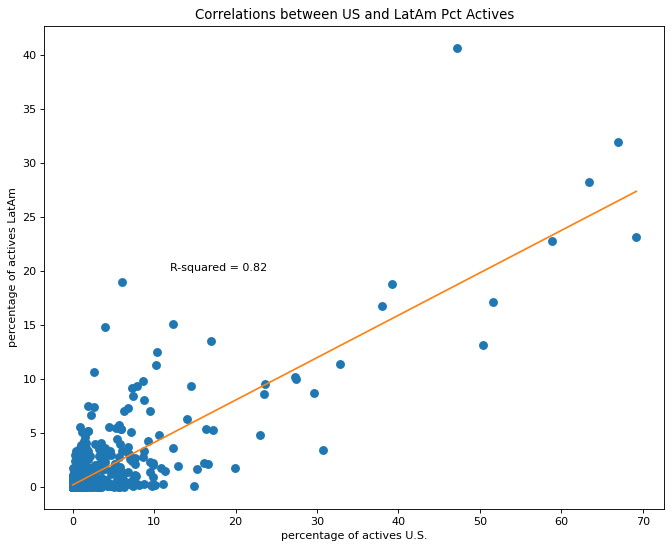

In [159]:
figure(figsize=(10, 8), dpi=80)
plt.scatter(pct_actives_all['pct_actives_us'], pct_actives_all['pct_actives'],
                linewidth=2)
plt.title('Correlations between US and LatAm Pct Actives')

linreg = st.linregress(pct_actives_all['pct_actives_us'], pct_actives_all['pct_actives'])
plt.plot(pct_actives_all['pct_actives_us'], 
         np.poly1d(np.polyfit(pct_actives_all['pct_actives_us'], 
                              pct_actives_all['pct_actives'], 1))\
         (pct_actives_all['pct_actives_us']),
        color = 'tab:orange')

plt.text(12, 20, 'R-squared = %0.2f' % linreg.rvalue)


plt.xlabel('percentage of actives U.S.')
plt.ylabel('percentage of actives LatAm')
plt.show()

In [20]:
run_query('''
select distinct geo.region, dim.territory from max_prod.catalog.reporting_asset_offering_dim dim
join "CORE"."GEO_MAP" geo
on geo.territory = dim.territory
where geo.region = 'LATAM'
''')

,region,territory
0,LATAM,ARGENTINA
1,LATAM,REST OF LATAM
2,LATAM,CARIBBEAN
3,LATAM,COLOMBIA
4,LATAM,BRAZIL
5,LATAM,MEXICO


# Bugs

In [175]:
daily_total_views = run_query('''
                        select
                        start_date AS available_date,
                        DAYS_SINCE_RELEASE + 1 AS days_on_hbo_max,
                        SUM(VIEWING_SUBS) AS cumulative_viewing_subs_denom
                        from "MAX_PROD"."CONTENT_ANALYTICS"."CUMULATIVE_SUBS_DENOM_LATAM"
                        where DAYS_SINCE_RELEASE< 28
                        group by 1, 2
                        order by start_date
                        '''
                          )
title_actives = run_query('''
with max_release_date_base as (
select
  distinct
  rad.title_id,
  case when rad.season_number is null then title_name else concat(rad.series_title_long,' S',rad.season_number) end as title,
  'Seasons and Movies' as title_level,
  first_value(raod.first_offered_date) over (partition by title order by raod.first_offered_date asc) as first_release_date,
  case when aod.offering_start_date <='2020-05-27 07:00:00' THEN '2020-05-27 07:00:00'
       else aod.offering_start_date end as offering_start_date,
  aod.offering_end_date
  , case when content_category = 'series' then ifnull(season_number, 1) else season_number end as season_number_adj
  , coalesce(concat(rad.series_id, '-', season_number_adj), rad.viewable_id) as match_id
from
  max_prod.catalog.reporting_asset_dim rad
join max_prod.catalog.asset_offering_dim aod
    on rad.viewable_id = aod.viewable_id
        and aod.offering_end_date>= '2021-06-29 09:00:00'
        AND aod.brand = 'HBO MAX'
join max_prod.catalog.reporting_asset_offering_dim raod
  on aod.viewable_id = raod.viewable_id
    AND aod.channel = raod.channel
    AND aod.brand = raod.brand
    AND raod.territory = aod.territory -- leave as HBO MAX domestic because no MUS?
where
  raod.first_offered_date is not null
  and rad.asset_type = 'FEATURE'
--   and offering_start_date<=sysdate()
  and aod.territory in ('BRAZIL', 'ARGENTINA', 'COLOMBIA', 'MEXICO', 'CARIBBEAN', 'REST OF LATAM')
 -- Exclude some odd titles
    ),
      second as (
        SELECT
           s1.title_id,
           s1.title,
           s1.title_level,
           s1.match_id,
           s1.first_release_date,
           s1.offering_start_date,
           MIN(t1.offering_end_date) AS offering_end_date
        FROM max_release_date_base s1
          INNER JOIN max_release_date_base t1 ON s1.offering_start_date <= t1.offering_end_date and s1.title_id=t1.title_id and s1.title=t1.title and s1.title_level=t1.title_level
            AND NOT EXISTS(SELECT * FROM max_release_date_base t2
                           WHERE t1.offering_end_date >= t2.offering_start_date AND t1.offering_end_date < t2.offering_end_date
                            and t1.title_id=t2.title_id and t1.title=t2.title
                          )
        WHERE NOT EXISTS(SELECT * FROM max_release_date_base s2
                           WHERE s1.offering_start_date > s2.offering_start_date AND s1.offering_start_date <= s2.offering_end_date
                            and s1.title_id=s2.title_id and s1.title=s2.title
                          )
        GROUP BY 1,2,3,4,5,6
        order by 1,2,3,4,5,6
      ),
      third as
        (SELECT
        title_id,
        title,
        title_level,
        match_id,
        max(offering_end_date) as end_date
        from second
        group by 1,2,3,4),
      fourth as
        (SELECT
         title_id,
        title,
        title_level,
        match_id,
        case when end_date>=sysdate() then FALSE
        else TRUE end as is_inactive
        from third),
       fifth as
         (SELECT
         title,
         title_id,
         title_level,
         max(days_on_hbo_max) as total_days
        from max_prod.content_intelligence.new_title_release_days_on_platform_latam
        group by 1,2,3)

SELECT c.match_id, a.title, a.first_release_date, a.DAILY_VIEWING_SUBS, a.CUMULATIVE_VIEWING_SUBS,
     a.days_on_hbo_max, a.title_id
FROM max_prod.content_intelligence.new_title_release_days_on_platform_latam a
inner join fifth b on initcap(a.title)=initcap(b.title) and a.title_id=b.title_id and a.title_level=b.title_level
inner join fourth c on initcap(a.title)=initcap(c.title) and a.title_id=c.title_id and a.title_level=c.title_level
where (days_on_hbo_max between 1 and 28)
''')

title_actives.drop_duplicates(inplace = True)
title_actives['available_date'] = title_actives['first_release_date'].astype(str).str[0:10:1]

pct_actives = pd.merge(title_actives[['match_id', 'title', 'title_id', 'days_on_hbo_max', 'available_date', 'cumulative_viewing_subs']],
              daily_total_views[['available_date', 'days_on_hbo_max', 'cumulative_viewing_subs_denom']],
              on = ['available_date', 'days_on_hbo_max'],
              how = 'inner')
pct_actives['pct_actives'] = pct_actives['cumulative_viewing_subs']/pct_actives['cumulative_viewing_subs_denom']*100
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))
pct_actives = pct_actives[['match_id', 'title', 'available_date', 'days_on_hbo_max', 'real_date' ,'pct_actives']]



In [176]:
# Join Metadata
metadata_feature = run_query('''with runtime_info as (
    select
        viewable_id
        -- different language version has different length,
        -- just take the average for simplicity
        , avg(credits_start_time) as credits_start_time
    from max_prod.catalog.asset_edit_dim as edit
    group by 1
),

metadata as (
    select distinct
        case when content_category = 'series'
                then ifnull(season_number, 1)
                else season_number
                    end as season_number_adj
        , coalesce(concat(series_id, '-', season_number_adj), asset.viewable_id) as match_id
        , asset.viewable_id
        , coalesce(concat(series_title_long, ' S', season_number_adj), asset_title_long) as title_name
        , case when program_type is null then 'unknown' else program_type end as program_type
        , asset.content_category
        , credits_start_time
        , release_year
        , licensor
        , descriptive_genre_desc
        , wm_enterprise_genres
        , navigation_genre_desc
from max_prod.catalog.asset_dim as asset
-- to get runtime data
left join runtime_info as edit
    on asset.viewable_id = edit.viewable_id
)

, meta_agg as (
    select
        m.match_id, title_name
        , season_number_adj
        , mode(m.program_type) as program_type
        , mode(m.content_category) as content_category
        , ifnull(sum(credits_start_time)/3600.0,-1) as total_hours
        , min(release_year) as prod_release_year
        , listagg(distinct lower(licensor), '|') as licensor_agg
        , listagg(distinct lower(descriptive_genre_desc), '|') as descriptive_genre_desc_agg
        , listagg(distinct lower(wm_enterprise_genres), '|') as wm_enterprise_genres_agg
        , listagg(distinct lower(navigation_genre_desc), '|') as navigation_genre_desc_agg
    from metadata as m
    group by 1,2, 3
),

fin_meta_data_table as (
    select distinct
        title_name
        , match_id
        , season_number_adj
        , program_type
        , content_category
        , prod_release_year
        , total_hours
        , licensor_agg
        , descriptive_genre_desc_agg
        , wm_enterprise_genres_agg
        , navigation_genre_desc_agg
    from meta_agg
    order by match_id
)

    select a.*
        , case when b.viewable_id is null then 0 else 1 end as popcorn_titles
    from fin_meta_data_table a
    left join MAX_PROD.CATALOG.POPCORN_TITLES b
    on a.match_id = b.viewable_id
    order by match_id'''
                      )


In [177]:
pct_actives=pd.merge(pct_actives,
                  metadata_feature.rename(columns = {'title_name':'id'}),
                  on = ['match_id'],how = 'left')
recent_originals = pct_actives[(pct_actives['program_type'] == 'original')
                     &(pct_actives['available_date'] > '2021-06-29')
                     ][['match_id', 'days_on_hbo_max', 'available_date']].drop_duplicates()
recent_originals['originals_after_launch'] = 1
recent_originals.drop_duplicates(inplace = True)

pct_actives = pd.merge(pct_actives, recent_originals[['match_id', 'originals_after_launch', 'days_on_hbo_max', 'available_date']],
                        on = ['match_id', 'days_on_hbo_max', 'available_date'], how = 'left')
pct_actives.loc[pct_actives['originals_after_launch'] == 1, 'originals_type'] = 'originals_after_launch'
pct_actives.loc[pct_actives['popcorn_titles'] == 1, 'originals_type'] = 'popcorn_titles'
pct_actives['originals_type'] = pct_actives['originals_type'].fillna(pct_actives['program_type'])
pct_actives = pct_actives.drop(['originals_after_launch', 'popcorn_titles'], axis = 1)
pct_actives['real_date'] = (pd.to_datetime(pct_actives['available_date']) +
                            pd.to_timedelta(pct_actives['days_on_hbo_max'], unit='D'))
pct_actives = pct_actives.rename(columns = {'season_number_adj':'season_number'})
pct_actives = pct_actives[['match_id', 'title', 'available_date', 'days_on_hbo_max',
                            'real_date' ,'pct_actives', 'season_number', 'program_type', 'content_category',
                            'prod_release_year', 'total_hours', 'originals_type']]


In [178]:
pct_actives.head()

,match_id,title,available_date,days_on_hbo_max,real_date,pct_actives,season_number,program_type,content_category,prod_release_year,total_hours,originals_type
0,GYF5TUQJ6gEXDwwEAAAAC,The Happytime Murders,2021-09-29,1,2021-09-30,0.147567,NaN,acquired,movies,2018.0,1.343888888889,acquired
1,GXyIPIgqdlp28vgEAAAJ9,The Lake House,2021-09-29,1,2021-09-30,0.054372,NaN,acquired,movies,2006.0,1.467638888889,acquired
2,GYMZl4Q7y8JhGigEAAABA,Pan,2021-09-29,1,2021-09-30,0.119829,NaN,acquired,movies,2015.0,1.687685185278,acquired
3,GYF49AAYm8gaavQEAAAFR,Peppermint,2021-09-29,1,2021-09-30,0.298814,NaN,acquired,movies,2018.0,1.545416666667,acquired
4,GYTERqQ4GvorCRwEAAACs,A Beautiful Mind,2021-09-29,1,2021-09-30,0.088917,NaN,acquired,movies,2001.0,2.085833333333,acquired


In [184]:
pct_actives.days_on_hbo_max.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])